In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [6]:
import pandas as pd
from matplotlib import pyplot
from math import sqrt 
import numpy as np 
import scipy.misc 
from IPython.display import display 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

data = pd.read_csv("drive/My Drive/fer2013.csv")
data.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [8]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [9]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

In [10]:
data.Usage.value_counts() 

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [11]:
depth = 1
height = int(sqrt(len(data.pixels[0].split()))) 
width = int(height)

In [13]:
train_set = data[(data.Usage == 'Training')] 
val_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')] 
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [14]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

In [15]:
y_train = train_set.emotion 
y_train = np_utils.to_categorical(y_train, num_classes) 
y_val = val_set.emotion 
y_val = np_utils.to_categorical(y_val, num_classes) 
y_test = test_set.emotion 
y_test = np_utils.to_categorical(y_test, num_classes) 

In [16]:
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

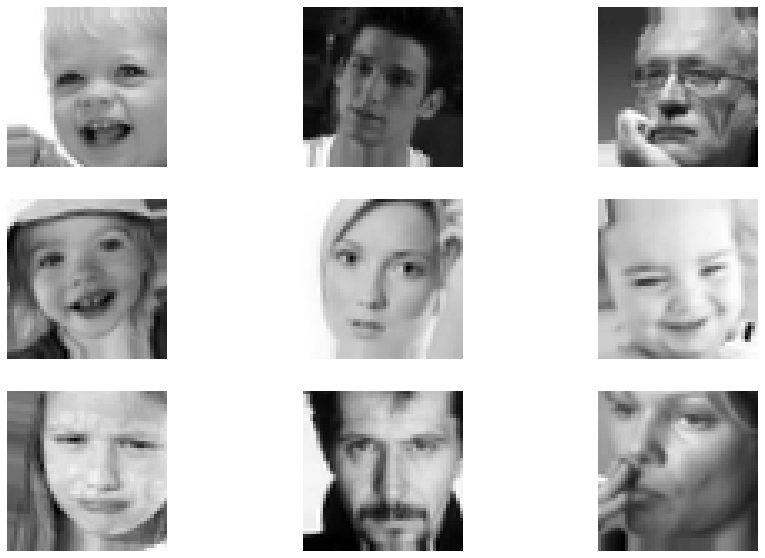

In [17]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        pyplot.axis('off') 
        pyplot.subplot(330 + 1 + i) 
        pyplot.imshow(X_batch[i].reshape(48, 48), cmap=pyplot.get_cmap('gray'))
    pyplot.axis('off') 
    pyplot.show() 
    break 

In [18]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size) 

In [19]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [20]:
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 24, 24, 64)        0         
_________________________________________________________________
drop1_1 (Dropout)            (None, 24, 24, 64)       

In [21]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [22]:
num_epochs = 200 # we iterate 200 times over the entire training set 
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200

Epoch 00001: val_loss improved from inf to 1.89992, saving model to weights_min_loss.hdf5
449/448 - 19s - loss: 2.0162 - accuracy: 0.2158 - val_loss: 1.8999 - val_accuracy: 0.2494
Epoch 2/200

Epoch 00002: val_loss improved from 1.89992 to 1.78678, saving model to weights_min_loss.hdf5
449/448 - 18s - loss: 1.7865 - accuracy: 0.2573 - val_loss: 1.7868 - val_accuracy: 0.2697
Epoch 3/200

Epoch 00003: val_loss improved from 1.78678 to 1.74725, saving model to weights_min_loss.hdf5
449/448 - 18s - loss: 1.7434 - accuracy: 0.2905 - val_loss: 1.7472 - val_accuracy: 0.3168
Epoch 4/200

Epoch 00004: val_loss improved from 1.74725 to 1.58650, saving model to weights_min_loss.hdf5
449/448 - 18s - loss: 1.6793 - accuracy: 0.3302 - val_loss: 1.5865 - val_accuracy: 0.3940
Epoch 5/200

Epoch 00005: val_loss improved from 1.58650 to 1.54648, saving model to weights_min_loss.hdf5
449/448 - 18s - loss: 1.6044 - ac

<Figure size 432x288 with 0 Axes>

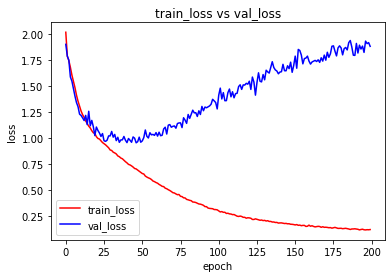

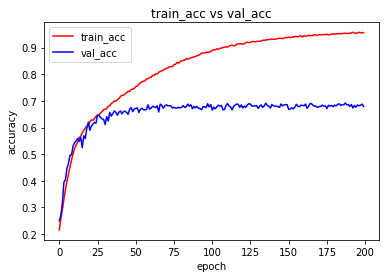

<Figure size 432x288 with 0 Axes>

In [24]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [25]:
loss = model.evaluate_generator(test_flow, steps=len(X_test) / batch_size) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test Loss 1.690818190574646
Test Acc: 0.699916422367096


In [26]:
model.save('Fer2013.hdf5') 

In [27]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 9ms/step - loss: 1.6908 - accuracy: 0.6999
Test Loss 1.6908178329467773
Test Acc: 0.699916422367096


In [28]:
loss = model.evaluate(X_val/255., y_val) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 9ms/step - loss: 1.8809 - accuracy: 0.6790
Test Loss 1.8809010982513428
Test Acc: 0.6790192127227783


In [30]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

In [31]:
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

113/113 [==============================] - 1s 8ms/step


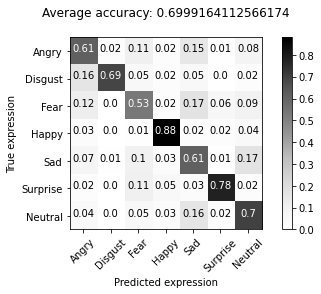

In [32]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')